In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%bash
# Logistics #2: install the transformers package, create a folder, download the dataset and a patch
pip -q install transformers
pip -q install datasets

# remove the directory if necessary
# rm -rf "/content/gdrive/MyDrive/6864_hw4/"

mkdir "/content/drive/My Drive/NLP/"
cd "/content/drive/My Drive/NLP/"

# wget http://nlp.stanford.edu/data/glove.6B.zip
# unzip glove.6B.zip
# ls
# pwd

mkdir: cannot create directory ‘/content/drive/My Drive/NLP/’: File exists


In [4]:
import numpy as np
import pandas as pd
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('There are %d GPU(s) available.' % torch.cuda.device_count())

  print('We will use the GPU:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [5]:
project_path = '/content/drive/My Drive/NLP/'
from datasets import load_dataset

dataset = load_dataset('liar')

Using custom data configuration default


Dataset liar downloaded and prepared to /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514. Subsequent calls will reuse this data.


In [ ]:
texts = np.array(dataset["train"]['statement'])
labels = np.array(dataset["train"]['label'])

texts[(labels != 1) & (labels != 4)].shape

(6489,)

In [ ]:
np.asarray(dataset["train"]["label"])

array([0, 1, 2, ..., 1, 0, 5])

In [6]:
def bin_labels(dataset):
  mapping = {
      0: 'false',
      1: 'half-true',
      2: 'mostly-true',
      3: 'true',
      4: 'barely-true',
      5: 'pants-fire'
  }
  texts = np.array(dataset['statement'])
  labels = np.array(dataset['label'])

  # filter out half-true and barely-true lukewarm examples -> hopefully model
  # performs better in terms of 0 and 1 precision and recall (ie confidence in preds)
  texts = texts[(labels != 1) & (labels != 4)]
  labels = labels[(labels != 1) & (labels != 4)]

  true = labels == 3
  mostly_true = labels == 2
  pos_labels = np.logical_or(true, mostly_true)
  labels = np.where(pos_labels, 1, 0)

  new_dataset = pd.DataFrame()
  new_dataset['text'] = texts
  new_dataset['label'] = labels
  return new_dataset

data_train = bin_labels(dataset['train'])
data_val = bin_labels(dataset['validation'])
data_test = bin_labels(dataset['test'])

In [ ]:
data_train

,text,label
0,Says the Annies List political group supports ...,0
1,"Hillary Clinton agrees with John McCain ""by vo...",1
2,Health care reform legislation is likely to ma...,0
3,The Chicago Bears have had more starting quart...,1
4,Says GOP primary opponents Glenn Grothman and ...,1
...,...,...
6484,Mayor Fung wants to punish our childrens educa...,0
6485,There are a larger number of shark attacks in ...,1
6486,Democrats have now become the party of the [At...,1
6487,On lifting the U.S. Cuban embargo and allowing...,0


In [ ]:
# import shit
from keras import callbacks
from keras.models import Sequential
from keras.layers import Activation,Flatten,Dense,Dropout,Embedding,Bidirectional,LSTM
from keras.optimizers import Adam,SGD

from keras.models import load_model
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pickle
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import gc
import keras.backend as K

In [ ]:
def create_model(vocabulary_size,embedding_size,embedding_matrix):
    model_glove = Sequential()
    model_glove.add(Embedding(vocabulary_size, embedding_size, weights=[embedding_matrix], trainable=False))
    model_glove.add(Bidirectional(LSTM(100)))
    model_glove.add(Dense(1, activation='sigmoid'))
    model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_glove.summary()
    return model_glove

def callback(model_name,tf_log_dir_name='./tf-log/',patience_lr=10,):
    cb = []
    """
    Tensorboard log callback
    """
    tb = callbacks.TensorBoard(log_dir=tf_log_dir_name, histogram_freq=0)
    cb.append(tb)

    """
    Model-Checkpoint
    """
    m = callbacks.ModelCheckpoint(filepath=model_name,monitor='val_loss',mode='auto',save_best_only=True)
    cb.append(m)

    """
    Reduce Learning Rate
    """
    reduce_lr_loss = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, epsilon=1e-4, mode='min')
    cb.append(reduce_lr_loss)

    """
    Early Stopping callback
    """
    # Uncomment for usage
    early_stop = callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
    cb.append(early_stop)

    return cb

######### Show Train Val History Graph ###############
def plot_loss_accu(history,lossLoc='Train_Val_Loss',accLoc='Train_Val_acc'):
    import matplotlib.pyplot as plt

    plt.clf()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation loss')
    plt.legend(['train', 'val'], loc='upper right')
    #plt.show()
    plt.savefig(lossLoc)

    plt.clf()

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and validation accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    #plt.show()
    plt.savefig(accLoc)

    return model_glove

In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk import re, SnowballStemmer

def clean_text(text):
    import nltk
    nltk.download('stopwords')
    translate_table = dict((ord(char), None) for char in string.punctuation)
    text = text.translate(translate_table)

    re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                        .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                        re.MULTILINE | re.UNICODE)
    re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

    text = re_url.sub("URL", text)

    text = re_ip.sub("IPADDRESS", text)

    text = text.lower().split()

    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]

    text = " ".join(text)

    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)


    return text

In [ ]:
vocabulary_size = 400000
time_step=300

texts=data_train['text']
label=data_train['label']

X=texts.map(lambda x: clean_text(x))

Streaming output truncated to the last 5000 lines.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-dat

In [ ]:
X

0       say anni list polit group support thirdtrimest...
1       hillari clinton agre john mccain vote give geo...
2       health care reform legisl like mandat free sex...
3       chicago bear start quarterback last year total...
4       say gop primari oppon glenn grothman joe leibh...
                              ...                        
6484    mayor fung want punish children educ remov mil...
6485    larger number shark attack florida case voter ...
6486        democrat becom parti atlanta metro area black
6487                 lift cuban embargo allow travel cuba
6488    depart veteran affair manual tell veteran stuf...
Name: text, Length: 6489, dtype: object

In [ ]:
labelEncoder=LabelEncoder()
encoded_label=labelEncoder.fit_transform(label)
y=np.reshape(encoded_label,(-1,1))


training_size=int(0.8*X.shape[0])
X_train=X[:training_size]
y_train=y[:training_size]
X_test=X[training_size:]
y_test=y[training_size:]


#Tokenizing texts
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(X_train)
sequences_train= tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(sequences_train, maxlen=time_step,padding='post')

print(len(tokenizer.word_index))


6705


In [ ]:
X_train.shape

(5191, 300)

In [ ]:
vocab_size=len(tokenizer.word_index)+1

#Reading Glove
f = open(project_path + 'glove.6B.100d.txt',encoding='utf-8')
embeddings={}
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings))

Total 400000 word vectors.


In [ ]:
embedding_size=100

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, embedding_size))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(6706, 100)


In [ ]:
sequences_test= tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(sequences_test, maxlen=time_step,padding='post')
vocab_size = embedding_matrix.shape[0]
vocab_size

6706

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)##################
cvscores_FR=[]
classfication_report=[]

Fold = 1
for train, val in kfold.split(X_train, y_train):
    gc.collect()
    K.clear_session()
    print('Fold: ', Fold)

    X_train_train = X_train[train]
    X_train_val = X_train[val]

    y_train_train = y_train[train]
    y_train_val = y_train[val]

    print("Initializing Callback :/...")
    model_name = 'Models/Bi_LSTM/Cross_Validation/Callbacks/FR/Model_cv_bi_lstm_FR_1_Callbacks_kfold_'+str(Fold)+'.h5'
    cb = callback(model_name=model_name) 
    # create model
    print("Creating and Fitting Model...")
    model = create_model(vocabulary_size=vocab_size,embedding_size=embedding_size,embedding_matrix=embedding_matrix)

    history=model.fit(X_train_train, y_train_train,validation_data=(X_train_val,y_train_val),
                      epochs=10, batch_size=128,shuffle=True,callbacks=cb)

    # Save each fold model
    print("Saving Model...")
    model_name = 'Models/Bi_LSTM/Cross_Validation/FR/Model_cv_bi_lstm_FR_1_kfold_' + str(Fold) + '.h5'########################################3
    model.save(model_name)
    '''
    model = load_model('Models/Bi_LSTM/Cross_Validation/FR/Model_cv_bi_lstm_FR_1_kfold_' + str(Fold) + '.h5')
    model.name='Model_bi_lstm_FR_1.h5'
    '''

    # evaluate the model
    print("Evaluating Model...")
    ##########################################
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Eval with Fake or Real %s: %.2f%%" % (model.metrics_names[1], scores[1]))
    cvscores_FR.append(scores[1])

    from sklearn.metrics import precision_recall_fscore_support, classification_report

    y_pred = model.predict_classes(X_test)
    classfication_report.append(classification_report(y_test, y_pred))
    #print('Classification report:\n', classification_report(y_test, y_pred))
    # print('Classification report:\n',precision_recall_fscore_support(y_test,y_pred))
    # print(y_pred)

    '''#######################################################
    ########### Saving Graph ####################
    print("Saving graph...")
    plot_loss_accu(history,'Graphs/Train_Val_Loss_Fold_'+str(Fold)+'.png','Graphs/Train_Val_Acc_Fold_'+str(Fold)+'.png')
    #######################################################'''

    Fold = Fold + 1

print("Accuracy list of Fake or Real: ",cvscores_FR)
print("%s: %.2f%%" % ("Mean Accuracy of Fake or Real: ", np.mean(cvscores_FR)))
print("%s: %.2f%%" % ("Standard Deviation of Fake or Real: +/-", np.std(cvscores_FR)))


print('Classfication Report:')
for cr in classfication_report:
    print(cr)

Fold:  1
Initializing Callback :/...
Creating and Fitting Model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         670600    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 831,601
Trainable params: 161,001
Non-trainable params: 670,600
_________________________________________________________________
Epoch 1/10
33/33 [==============================] - 7s 112ms/step - loss: 0.6761 - accuracy: 0.5515 - val_loss: 0.6513 - val_accuracy: 0.6112
Epoch 2/10
33/33 [==============================] - 2s 54ms/step - loss: 0.6463 - accuracy: 0.6202 - val_loss: 0.6500 - val_accuracy: 0.6102
Epoch 3/10
33/33 [======

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Fold:  2
Initializing Callback :/...
Creating and Fitting Model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         670600    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 831,601
Trainable params: 161,001
Non-trainable params: 670,600
_________________________________________________________________
Epoch 1/10
33/33 [==============================] - 7s 113ms/step - loss: 0.6788 - accuracy: 0.5501 - val_loss: 0.6562 - val_accuracy: 0.6031
Epoch 2/10
33/33 [==============================] - 2s 55ms/step - loss: 0.6526 - accuracy: 0.6128 - val_loss: 0.6509 - val_accuracy: 0.6156
Epoch 3/10
33/33 [======

In [ ]:
misclassified = []
for i, row in data_test.iterrows():
  if model.fit
  data_test

,text,label
0,Building a wall on the U.S.-Mexico border will...,1
1,Wisconsin is on pace to double the number of l...,0
2,Says John McCain has done nothing to help the ...,0
3,When asked by a reporter whether hes at the ce...,0
4,Over the past five years the federal governmen...,1
...,...,...
797,Says Chris Christies plan to kick-start our ec...,0
798,Obama used $20 million in federal money to emm...,0
799,I think its seven or eight of the California s...,0
800,Sen. Bob Menendez voted to enact a new tax on ...,0


In [ ]:
model.predict(data_test['text'].to_numpy())

UnimplementedError: ignored

In [ ]:
y_test_pred = model.predict(X_test)

In [ ]:
X_test[((y_test_pred >= 0.5) == y_test)]

IndexError: ignored

In [ ]:
((y_test_pred >= 0.5) == y_test).shape

(1298, 1)

In [ ]:
X_test_readable=X[training_size:]
pd.set_option("max_colwidth", 200)
pd.set_option("display.max_rows", 60)
df_incorrect = pd.DataFrame(X_test_readable[((y_test_pred >= 0.5) != y_test)[:, 0]]).reset_index(drop=True)
df_correct = pd.DataFrame(X_test_readable[((y_test_pred >= 0.5) == y_test)[:, 0]]).reset_index(drop=True)


In [ ]:
pd.options.display.max_rows

60

In [ ]:
df_incorrect['label'] = (y_test[((y_test_pred >= 0.5) != y_test)[:, 0]])
df_incorrect[df_incorrect['text'].str.contains('republican')].describe()

,label
count,21.000000
mean,0.380952
std,0.497613
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
21 * 0.38

7.98

In [ ]:
df_correct['label'] = (y_test[((y_test_pred >= 0.5) == y_test)[:, 0]])
df_correct[df_correct['text'].str.contains('republican')].describe()

,label
count,25.00000
mean,0.76000
std,0.43589
min,0.00000
25%,1.00000
50%,1.00000
75%,1.00000
max,1.00000


In [ ]:
df_incorrect

,text,label
0,wisconsin pension system one fulli fund countri,1
1,say tax plan senior make less 50000 per year wont pay incom tax,1
2,kind snowstorm happen everi year,1
3,koch brother spend money either democrat republican parti 2016 elect,0
4,say jeb bush oppos marriag equal hes said person believ gay coupl ban adopt children,1
...,...,...
510,race democrat top target novemb,0
511,result obamacar california senior face benefit cut 1700,0
512,say rick perri turn invit meet presid barack obama paso,1
513,mayor fung want punish children educ remov million dollar current fund pay privat charter school tax would increas percent per year,0


In [ ]:
df_total = pd.DataFrame(index=range(10269))
for feature in dataset['train'].features:
  # print(len(dataset['train'][feature]))
  df_total[feature] = dataset['train'][feature]
df_total

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,0,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,1,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,2,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,0,Health care reform legislation is likely to mandate free sex change surgeries.,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,1,The economic turnaround started at the end of my term.,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10264,5473.json,2,There are a larger number of shark attacks in Florida than there are cases of voter fraud.,"animals,elections",aclu-florida,,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10265,3408.json,2,Democrats have now become the party of the [Atlanta] metro area and of blacks.,elections,alan-powell,,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10266,3959.json,1,"Says an alternative to Social Security that operates in Galveston County, Texas, has meant that participants will retire with a whole lot more money than under Social Security.","retirement,social-security",herman-cain,,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate
10267,2253.json,0,On lifting the U.S. Cuban embargo and allowing travel to Cuba.,"florida,foreign-policy",jeff-greene,,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against Kendrick Meek.


In [ ]:
df_test = df_total[~df_total['label'].isin([1, 4])].iloc[training_size:]
df_test

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
8210,706.json,5,Says Obama called Sarah Palin a pig.,candidates-biography,john-mccain,U.S. senator,Arizona,republican,31.0,39.0,31.0,37.0,8.0,a Web ad
8211,11190.json,2,Wisconsins pension system is the only one fully funded in the country.,"disability,pensions,retirement,state-finances,states",scott-walker,Milwaukee County Executive,Wisconsin,republican,26.0,41.0,32.0,40.0,11.0,a tweet
8212,756.json,3,"Says that under his tax plan, seniors making less than $50,000 per year won't pay any income taxes.",taxes,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,a TV ad.
8213,3060.json,3,This kind of snowstorm happens every 10 or 15 years.,weather,john-eaves,Fulton County Board of Commissioners Chairman,Georgia,democrat,0.0,0.0,0.0,1.0,0.0,a newspaper article
8214,11531.json,0,The Koch Brothers are spending more money than either the Democratic or Republican parties in the 2016 elections.,"campaign-finance,elections",bernie-s,U.S. Senator,Vermont,independent,18.0,12.0,22.0,41.0,0.0,a speech.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10262,4388.json,5,Mayor Fung wants to punish our childrens education by removing 12 million dollars from current funding to pay for his private charter school. Your taxes would increase by between 6 and 8 percent p...,"children,city-budget,deficit,education,state-budget,taxes",richard-tomlins,,Rhode Island,democrat,0.0,0.0,0.0,0.0,1.0,a recorded telephone message to Cranston residents
10264,5473.json,2,There are a larger number of shark attacks in Florida than there are cases of voter fraud.,"animals,elections",aclu-florida,,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10265,3408.json,2,Democrats have now become the party of the [Atlanta] metro area and of blacks.,elections,alan-powell,,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10267,2253.json,0,On lifting the U.S. Cuban embargo and allowing travel to Cuba.,"florida,foreign-policy",jeff-greene,,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against Kendrick Meek.


In [ ]:
pd.DataFrame(df_test[misclassified & (y_test == 0)[:, 0]])['speaker'].value_counts()

barack-obama       12
mitt-romney         8
chain-email         7
facebook-posts      6
hillary-clinton     6
                   ..
jon-stewart         1
debra-lehrmann      1
ken-cuccinelli      1
austan-goolsbee     1
blog-posting        1
Name: speaker, Length: 183, dtype: int64

In [ ]:
pd.DataFrame(df_test[classified & (y_test == 0)[:, 0]])['speaker'].value_counts()

donald-trump                21
chain-email                 14
barack-obama                10
mitt-romney                  9
facebook-posts               7
                            ..
david-rivera                 1
george-will                  1
florida-chamber-commerce     1
shelley-adler                1
richard-durbin               1
Name: speaker, Length: 223, dtype: int64

In [ ]:
pd.DataFrame(df_test[classified & (y_test == 1)[:, 0]])['speaker'].value_counts()

barack-obama         29
hillary-clinton      16
rick-scott            8
rick-perry            7
mitt-romney           7
                     ..
kathleen-sebelius     1
bill-clinton          1
kay-hagan             1
jamie-radtke          1
rahm-emanuel          1
Name: speaker, Length: 301, dtype: int64

In [ ]:
pd.DataFrame(df_test[misclassified & (y_test == 1)[:, 0]])['speaker'].value_counts()

barack-obama               16
hillary-clinton            10
mitt-romney                 5
scott-walker                5
rick-scott                  4
                           ..
lloyd-doggett               1
austan-goolsbee             1
arizona-house-democrats     1
david-axelrod               1
rahm-emanuel                1
Name: speaker, Length: 191, dtype: int64

In [ ]:
df_test.shape

(1298, 14)

In [ ]:
misclassified = ((y_test_pred >= 0.5) != y_test)[:, 0] 
classified = ((y_test_pred >= 0.5) == y_test)[:, 0] 

In [ ]:
(y_test == 1).shape

(1298, 1)

In [ ]:
y_test == 1

array([[False],
       [ True],
       [ True],
       ...,
       [ True],
       [False],
       [False]])

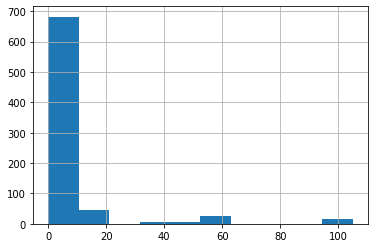

In [ ]:
pd.DataFrame(df_test[((y_test_pred >= 0.5) == y_test)[:, 0]])['pants_on_fire_counts'].hist()

In [ ]:
df_test[((y_test_pred >= 0.5) != y_test)[:, 0]]

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
8211,11190.json,2,Wisconsins pension system is the only one fully funded in the country.,"disability,pensions,retirement,state-finances,states",scott-walker,Milwaukee County Executive,Wisconsin,republican,26.0,41.0,32.0,40.0,11.0,a tweet
8212,756.json,3,"Says that under his tax plan, seniors making less than $50,000 per year won't pay any income taxes.",taxes,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,a TV ad.
8213,3060.json,3,This kind of snowstorm happens every 10 or 15 years.,weather,john-eaves,Fulton County Board of Commissioners Chairman,Georgia,democrat,0.0,0.0,0.0,1.0,0.0,a newspaper article
8214,11531.json,0,The Koch Brothers are spending more money than either the Democratic or Republican parties in the 2016 elections.,"campaign-finance,elections",bernie-s,U.S. Senator,Vermont,independent,18.0,12.0,22.0,41.0,0.0,a speech.
8215,10349.json,2,"Says Jeb Bush not only opposes marriage equality, hes said he personally believes gay couples should be banned from adopting children.","children,corrections-and-updates,families,gays-and-lesbians",democratic-national-committee,,,none,8.0,2.0,10.0,8.0,0.0,a list of talking points
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10247,1674.json,0,This race will be the Democrats top target this November.,"elections,states",debra-lehrmann,,,republican,0.0,1.0,0.0,0.0,0.0,a mailer
10250,10166.json,0,"As a result of Obamacare, California seniors face benefit cuts of over $1,700.","federal-budget,health-care,medicare,message-machine-2014",american-crossroads,,,republican,5.0,5.0,4.0,0.0,0.0,a campaign ad
10252,3744.json,2,Says Rick Perry turned down our invitation to meet President Barack Obama in El Paso.,"bipartisanship,immigration",jay-carney,White House press secretary,District of Columbia,none,2.0,2.0,1.0,2.0,0.0,a press gaggle aboard Air Force One.
10262,4388.json,5,Mayor Fung wants to punish our childrens education by removing 12 million dollars from current funding to pay for his private charter school. Your taxes would increase by between 6 and 8 percent p...,"children,city-budget,deficit,education,state-budget,taxes",richard-tomlins,,Rhode Island,democrat,0.0,0.0,0.0,0.0,1.0,a recorded telephone message to Cranston residents


In [7]:
data_test

,text,label
0,Building a wall on the U.S.-Mexico border will...,1
1,Wisconsin is on pace to double the number of l...,0
2,Says John McCain has done nothing to help the ...,0
3,When asked by a reporter whether hes at the ce...,0
4,Over the past five years the federal governmen...,1
...,...,...
797,Says Chris Christies plan to kick-start our ec...,0
798,Obama used $20 million in federal money to emm...,0
799,I think its seven or eight of the California s...,0
800,Sen. Bob Menendez voted to enact a new tax on ...,0


In [13]:
df_test = pd.DataFrame(index=range(1283))
for feature in dataset['test'].features:
  # print(len(dataset['train'][feature]))
  df_test[feature] = dataset['test'][feature]
df_test['label'] = df_test['label'].apply(lambda x: {
      0: 'false',
      1: 'half-true',
      2: 'mostly-true',
      3: 'true',
      4: 'barely-true',
      5: 'pants-fire'
  }[x])

In [14]:
df_test[df_test['speaker']=='rachel-maddow']

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
102,3161.json,mostly-true,"From 1980 to 1990, the top 1 percent saw their...","economy,history,income,pundits,taxes",rachel-maddow,MSNBC host,,none,6.0,6.0,4.0,6.0,1.0,"HBO's ""Real Time with Bill Maher"""
761,1324.json,barely-true,The Stupak Amendment doesnt just say you cant ...,"abortion,health-care,pundits",rachel-maddow,MSNBC host,,none,6.0,6.0,4.0,6.0,1.0,her show on MSNBC
915,9432.json,mostly-true,"In February, John McCain suggested the Bergdah...","afghanistan,foreign-policy",rachel-maddow,MSNBC host,,none,6.0,6.0,4.0,6.0,1.0,"a broadcast of the ""Rachel Maddow Show"""
1005,985.json,false,Gov. Sarah Palin got precisely zero support fo...,"elections,pundits",rachel-maddow,MSNBC host,,none,6.0,6.0,4.0,6.0,1.0,an episode of her MSNBC show
1056,2217.json,half-true,We know that tax cuts are remarkably un-stimul...,"economy,pundits,stimulus,taxes",rachel-maddow,MSNBC host,,none,6.0,6.0,4.0,6.0,1.0,"the ""Rachel Maddow Show"""
1062,8946.json,true,When the Dallas/Fort Worth Airport needed to s...,"energy,environment",rachel-maddow,MSNBC host,,none,6.0,6.0,4.0,6.0,1.0,"a broadcast of MSNBC's ""The Rachel Maddow Show"""
